# Outline

* cross sectional regression (problem of confoundedness)
* panel with unit fixed effects
    * unobserved time-varying confounders
    * short-run vs. long-run variation (adaptation)
    * average response vs. hetergeneity
    * "lack of variation"
* panel with unit fixed effects and trends
    * linear vs. quadratic trends
    * single vs. hetergeneous trends
* panel with time fixed effects
    * more flexible than trends
    * more likely to result in "lack of variation"
    * difficult to think about what the variation is (deviations from panel unit mean, again transformed to deviations from time period mean)

# Preliminaries

## Set up environment

* Install anaconda python from [here](https://www.continuum.io/downloads)
* Install julia from [here](http://julialang.org/downloads/)
* Add the following packages to julia using `Pkg.add()` from within julia:
    * IJulia (for interactive notebooks)
    * Gadfly (for plotting)
    * DataFrames (for working with tabular data)
    * FixedEffectModels (for high-dimensional panel regressions)
    * most of the rest of the packages listed [here](http://juliastats.github.io/) (Not used in this exercise, but will probably be useful in the future. In particular, it might be cool to add code to do cross validation of the regressions.)

## Load Packages

In [ ]:
using DataFrames
using FixedEffectModels
using Gadfly;

## Define functions

These will be used to quickly create objects that can be used in regressions and plotting

In [194]:
function create_wide_df(Y1, Y2, T1, T2, t)
    dfWide = DataFrame(Y1 = Y1, Y2 = Y2, T1 = T1, T2 = T2, t = t)
    dfWide[:mo] = dfWide[:t] % 12
    dfWide[dfWide[:mo].==0,:mo] = 12
    dfWide[:yr] = round(Int64, ceil(dfWide[:t] / 12))
    
    return dfWide
end

create_wide_df (generic function with 1 method)

In [195]:
function create_long_df(dfWide)
    dfT = rename(stack(dfWide, [:T1, :T2], [:t, :mo, :yr]), Dict{Any,Any}(:variable => :i, :value => :T))
    dfT[:i] = map(x->parse(Int64, string(x)[end]), dfT[:,:i])
    dfY = rename(stack(dfWide, [:Y1, :Y2], [:t, :mo, :yr]), Dict{Any,Any}(:variable => :i, :value => :Y))
    dfY[:i] = map(x->parse(Int64, string(x)[end]), dfY[:,:i])
    dfLong = join(dfY, dfT, on=[:i, :t, :mo, :yr])
    dfLong[:i] = pool(dfLong[:i])
    dfLong[:mo] = pool(dfLong[:mo])
    dfLong[:yr] = pool(dfLong[:yr])
    
    return dfLong
end

create_long_df (generic function with 1 method)

# Main exercise

## Cross-section

Below I set up a simple simulation of the temperature-outcome relationship in 2 distinct observational units

In [373]:
t = 1:360 # generic time period counter
# Panel unit 1
T1 = randn(360)*5+300 # temperatures normally distributed around 300
e1 = randn(360)*5 # white noise error
Y1 = 50*T1 + e1 + t - 14000 # coefficient of 50, secular trend, and a vertical shift for plotting

# Panel unit 1
T2 = randn(360)*5+320 # slightly higher average temperature
e2 = randn(360)*5 # white noise error
Y2 = 10*T2 + e2 + 2*t - 3000 # coefficient of 10, secular trend, and a vertical shift for plotting

# it will be helpful to refer to the data at different times using a DataFrame that is either wide or long
dfWide = create_wide_df(Y1, Y2, T1, T2, t);
dfLong = create_long_df(dfWide);

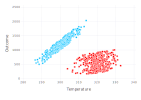

In [374]:
plot(
    layer(x=T1, y=Y1, Geom.point),
    layer(x=T2, y=Y2, Geom.point, Theme(default_color=colorant"red")),
    Guide.xlabel("Temperature"), Guide.ylabel("Outcome")
)

A very naive approach might compare the difference in average outcomes and divide by the difference in average temperatures

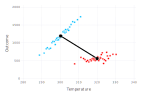

In [375]:
# calculate average outcome and average temperature for each panel unit
Ybar = [mean(dfWide[:Y1]), mean(dfWide[:Y2])]
Tbar = [mean(dfWide[:T1]), mean(dfWide[:T2])];

# demonstrate use of `Stat.binmean` to reduce number of data points plotted
plot(
    layer(x=Tbar, y=Ybar, Geom.point, Geom.line, order=1, Theme(default_color=colorant"black", default_point_size=5pt, line_width=3pt)), 
    layer(dfWide, x=:T1, y=:Y1, Stat.binmean(n=36), Geom.point),
    layer(dfWide, x=:T2, y=:Y2, Stat.binmean(n=36), Geom.point, Theme(default_color=colorant"red")),
    Guide.xlabel("Temperature"), Guide.ylabel("Outcome")
)

A somewhat less naive comparison would be to "pool" observations and regress all of the outcomes on all of the temperatures

In [376]:
reg(Y ~ T, dfLong)

                            Linear Model                            
Number of obs:                720   Degree of freedom:              2
R2:                         0.290   R2 Adjusted:                0.289
F Statistic:              293.183   p-value:                    0.000
             Estimate Std.Error  t value Pr(>|t|) Lower 95% Upper 95%
T            -19.4571   1.13634 -17.1226    0.000   -21.688  -17.2261
(Intercept)   6911.66   352.648  19.5993    0.000   6219.31    7604.0


---------------------------------------------------------------------


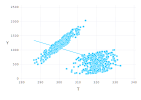

In [377]:
plot(
    layer(dfLong, x=:T, y=:Y, Geom.point),
    layer(dfLong, x=:T, y=:Y, Geom.smooth(method=:lm)),
)

But, if we estimate the same model over a subset of the observations, we get very different coefficients.

In [378]:
mod1 = reg(Y ~ T, dfLong[dfLong[:i].==1,:])

                            Linear Model                            
Number of obs:                360   Degree of freedom:              2
R2:                         0.855   R2 Adjusted:                0.855
F Statistic:              2116.94   p-value:                    0.000
             Estimate Std.Error  t value Pr(>|t|) Lower 95% Upper 95%
T             50.2787   1.09277  46.0102    0.000   48.1297   52.4278
(Intercept)  -13903.0   328.152 -42.3676    0.000  -14548.4  -13257.7


---------------------------------------------------------------------


In [379]:
mod2 = reg(Y ~ T, dfLong[dfLong[:i].==2,:])

                            Linear Model                            
Number of obs:                360   Degree of freedom:              2
R2:                         0.040   R2 Adjusted:                0.037
F Statistic:              14.9078   p-value:                    0.000
             Estimate Std.Error  t value Pr(>|t|) Lower 95% Upper 95%
T             8.68068   2.24826  3.86107    0.000   4.25922   13.1021
(Intercept)  -2216.76   719.591 -3.08058    0.002  -3631.91    -801.6


---------------------------------------------------------------------


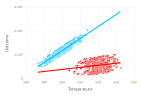

In [380]:
a1, b1 = coef(mod1)
a2, b2 = coef(mod2)
x = minimum(dfLong[:T]):maximum(dfLong[:T]);

plot(
    layer(dfWide, x="T1", y="Y1", Geom.point), 
    layer(x=x, y=a1+b1*x, Geom.line, Theme(line_width=3pt), order=1), 
    layer(dfWide, x="T2", y="Y2", Geom.point, Theme(default_color=colorant"red")), 
    layer(x=x, y=a2+b2*x, Geom.line, Theme(line_width=3pt, default_color=colorant"red"), order=1), 
    Guide.xlabel("Temperature"), Guide.ylabel("Outcome")
)

Using the fact that we know these observation come from two distinct observational units, we can control for heterogeneity that is constant within a panel unit (and correlated with our regressors) using a panel unit fixed effect.

In [381]:
mod_panelfe = reg(Y ~ T |> i, dfLong)

                     Fixed Effect Model                     
Number of obs:            720  Degree of freedom:          3
R2:                     0.764  R2 within:              0.372
F-Statistic:          425.369  p-value:                0.000
Iterations:                 1  Converged:               true
     Estimate Std.Error t value Pr(>|t|) Lower 95% Upper 95%
T     30.1219   1.46049 20.6245    0.000   27.2546   32.9893


------------------------------------------------------------


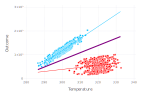

In [387]:
a = -8250
b_panelfe = coef(mod_panelfe)[1]

plot(
    layer(dfWide, x="T1", y="Y1", Geom.point), 
    layer(x=x, y=a1+b1*x, Geom.line, Theme(line_width=1pt), order=1), 
    layer(dfWide, x="T2", y="Y2", Geom.point, Theme(default_color=colorant"red")), 
    layer(x=x, y=a2+b2*x, Geom.line, Theme(line_width=1pt, default_color=colorant"red"), order=1), 
    layer(x=x, y=a+b_panelfe*x, Geom.line, Theme(line_width=3pt, default_color=colorant"purple"), order=1),
    Guide.xlabel("Temperature"), Guide.ylabel("Outcome")
)

In [388]:
dfLong[:Ytilde] = dfLong[:Y] - mean(dfLong[dfLong[:i].==1, :Y])
dfLong[dfLong[:i].==2, :Ytilde] = dfLong[dfLong[:i].==2, :Y] - mean(dfLong[dfLong[:i].==2, :Y])

dfLong[:Ttilde] = dfLong[:T] - mean(dfLong[dfLong[:i].==1, :T])
dfLong[dfLong[:i].==2, :Ttilde] = dfLong[dfLong[:i].==2, :T] - mean(dfLong[dfLong[:i].==2, :T])

mod_deviation = reg(Ytilde ~ Ttilde, dfLong)

                               Linear Model                               
Number of obs:                   720   Degree of freedom:                 2
R2:                            0.372   R2 Adjusted:                   0.371
F Statistic:                 425.963   p-value:                       0.000
                Estimate Std.Error     t value Pr(>|t|) Lower 95% Upper 95%
Ttilde           30.1219   1.45948     20.6389    0.000   27.2566   32.9873
(Intercept)  4.35167e-13   7.24459 6.00679e-14    1.000  -14.2231   14.2231


---------------------------------------------------------------------------


Here, the key assumption required to interpret the temperature coefficient causally is that the deviation of temperature from the *within unit* average is exogenous. If so, then we have estimated the response to *short run* changes in temperature. There may be reason to believe that this response would change over time, either dampening as  units "gain experience" with similar exogenous temperature shocks, or possibly increasing as simple (cheap) adaptation measures are exhausted or become marginally more expensive.

## Trends and time fixed effects

### Trends

Single trend, heterogeneous trends

In [214]:
t = 1:360
T1 = randn(360)*5+300 + t/25
T2 = randn(360)*5+320 + t/5
e1 = randn(360)*5
e2 = randn(360)*5
Y1 = 50*T1 + e1 + 2*t - 14000
Y2 = 10*T2 + e2 + 4*t - 3000

# it will be helpful to refer to the data at different times using a DataFrame that is either wide or long
dfWide = create_wide_df(Y1, Y2, T1, T2, t);
dfLong = create_long_df(dfWide);

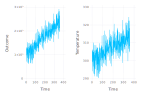

In [230]:
p1 = plot(x=t, y=Y1, Geom.line, Guide.xlabel("Time"), Guide.ylabel("Outcome"))
p2 = plot(x=t, y=T1, Geom.line, Guide.xlabel("Time"), Guide.ylabel("Temperature"))

hstack(p1, p2)

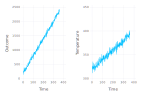

In [229]:
p1 = plot(x=t, y=Y2, Geom.line, Guide.xlabel("Time"), Guide.ylabel("Outcome"))
p2 = plot(x=t, y=T2, Geom.line, Guide.xlabel("Time"), Guide.ylabel("Temperature"))

hstack(p1, p2)

Because of the correlation between temperature and the exogenous trend, the temperature coefficient is biased.

In [231]:
mod1 = reg(Y ~ T, dfLong[dfLong[:i].==1,:])

                            Linear Model                            
Number of obs:                360   Degree of freedom:              2
R2:                         0.881   R2 Adjusted:                0.880
F Statistic:              2638.23   p-value:                    0.000
             Estimate Std.Error  t value Pr(>|t|) Lower 95% Upper 95%
T             71.2472   1.38711  51.3638    0.000   68.5193   73.9751
(Intercept)  -20160.8   425.891 -47.3379    0.000  -20998.3  -19323.2


---------------------------------------------------------------------


In [232]:
mod2 = reg(Y ~ T, dfLong[dfLong[:i].==2,:])

                            Linear Model                            
Number of obs:                360   Degree of freedom:              2
R2:                         0.978   R2 Adjusted:                0.978
F Statistic:              15870.4   p-value:                    0.000
             Estimate Std.Error  t value Pr(>|t|) Lower 95% Upper 95%
T             28.9627  0.229903  125.978    0.000   28.5106   29.4148
(Intercept)  -9029.68   82.0067 -110.109    0.000  -9190.96   -8868.4


---------------------------------------------------------------------


This bias also affects the ATE that we estimate.

In [233]:
reg(Y ~ T + t |> i, dfLong)

                     Fixed Effect Model                     
Number of obs:            720  Degree of freedom:          4
R2:                     0.960  R2 within:              0.954
F-Statistic:          3701.16  p-value:                0.000
Iterations:                 1  Converged:               true
     Estimate Std.Error t value Pr(>|t|) Lower 95% Upper 95%
T     17.1696  0.456283 37.6293    0.000   16.2738   18.0655
t     2.89725 0.0690558 41.9553    0.000   2.76168   3.03283


------------------------------------------------------------


But, controlling for a linear trend allows us to recover the true temperature coefficient for each unit, as well as the same ATE that we estimated before introducing the endogeneity problem.

In [238]:
mod1 = reg(Y ~ T + t, dfLong[dfLong[:i].==1,:])

                             Linear Model                             
Number of obs:                 360  Degree of freedom:               3
R2:                          1.000  R2 Adjusted:                 1.000
F Statistic:             1.35851e6  p-value:                     0.000
             Estimate  Std.Error  t value Pr(>|t|) Lower 95% Upper 95%
T             49.9385  0.0551993  904.696    0.000     49.83   50.0471
t             2.00519 0.00327501  612.269    0.000   1.99874   2.01163
(Intercept)  -13981.5    16.5804 -843.256    0.000  -14014.2  -13948.9


----------------------------------------------------------------------


In [239]:
mod2 = reg(Y ~ T + t, dfLong[dfLong[:i].==2,:])

                            Linear Model                            
Number of obs:                360   Degree of freedom:              3
R2:                         1.000   R2 Adjusted:                1.000
F Statistic:            5.96236e5   p-value:                    0.000
             Estimate Std.Error  t value Pr(>|t|) Lower 95% Upper 95%
T             10.0396 0.0581236  172.728    0.000   9.92525   10.1539
t             3.99263 0.0119528  334.032    0.000   3.96912   4.01614
(Intercept)  -3012.58    18.601 -161.958    0.000  -3049.16   -2976.0


---------------------------------------------------------------------


In [244]:
reg(Y ~ T |> i + i&t, dfLong)

                     Fixed Effect Model                     
Number of obs:            720  Degree of freedom:          5
R2:                     0.974  R2 within:              0.693
F-Statistic:          1613.45  p-value:                0.000
Iterations:                 2  Converged:               true
     Estimate Std.Error t value Pr(>|t|) Lower 95% Upper 95%
T      30.011  0.747142 40.1677    0.000   28.5442   31.4779


------------------------------------------------------------


Not allowing for heterogeneous trends results in a biased ATE

In [248]:
reg(Y ~ T + t|> i, dfLong)

                     Fixed Effect Model                     
Number of obs:            720  Degree of freedom:          4
R2:                     0.960  R2 within:              0.954
F-Statistic:          3701.16  p-value:                0.000
Iterations:                 1  Converged:               true
     Estimate Std.Error t value Pr(>|t|) Lower 95% Upper 95%
T     17.1696  0.456283 37.6293    0.000   16.2738   18.0655
t     2.89725 0.0690558 41.9553    0.000   2.76168   3.03283


------------------------------------------------------------


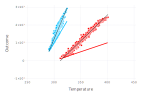

In [243]:
a1, b1 = coef(mod1)
a2, b2 = coef(mod2)
x1 = minimum(dfLong[dfLong[:i].==1, :T]):maximum(dfLong[dfLong[:i].==1, :T]);
x2 = minimum(dfLong[dfLong[:i].==2, :T]):maximum(dfLong[dfLong[:i].==2, :T]);

plot(
    layer(dfLong[dfLong[:i].==1,:], x=:T, y=:Y, Geom.point),
    layer(dfLong[dfLong[:i].==1,:], x=:T, y=:Y, Geom.smooth(method=:lm), Theme(default_color=colorant"black"), order=1),
    layer(x=x1, y=a1+b1*x1, Geom.line, Theme(line_width=2pt), order=1), 
    layer(dfLong[dfLong[:i].==2,:], x=:T, y=:Y, Geom.point, Theme(default_color=colorant"red")),
    layer(dfLong[dfLong[:i].==2,:], x=:T, y=:Y, Geom.smooth(method=:lm), Theme(default_color=colorant"black"), order=1),
    layer(x=x2, y=a2+b2*x2, Geom.line, Theme(line_width=2pt, default_color=colorant"red"), order=1), 
    Guide.xlabel("Temperature"), Guide.ylabel("Outcome")
)

### Time fixed effects

If the endogenous, time-varying component of temperature *is not* monotonic but *is* common to both panel units, then controlling for trends might not work.

In [366]:
t = 1:360
X = -30*cos(t/90);
T1 = randn(360)*5+300 + X
T2 = randn(360)*5+320 + X 
e1 = randn(360)*5
e2 = randn(360)*5
Y1 = 50*T1 + e1 + X - 14000 # opposite signs on X should produce negative correlation, downward bias on T1 coefficient
Y2 = 10*T2 + e2 + X - 3000 # opposite signs on X should produce negative correlation, downward bias on T2 coefficient

# it will be helpful to refer to the data at different times using a DataFrame that is either wide or long
dfWide = create_wide_df(Y1, Y2, T1, T2, t);
dfLong = create_long_df(dfWide);

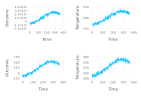

In [367]:
p1 = plot(x=t, y=Y1, Geom.line, Guide.xlabel("Time"), Guide.ylabel("Outcome"))
p2 = plot(x=t, y=T1, Geom.line, Guide.xlabel("Time"), Guide.ylabel("Temperature"))

pp1 = hstack(p1, p2)
p1 = plot(x=t, y=Y2, Geom.line, Guide.xlabel("Time"), Guide.ylabel("Outcome"))
p2 = plot(x=t, y=T2, Geom.line, Guide.xlabel("Time"), Guide.ylabel("Temperature"))

pp2 = hstack(p1, p2)
vstack(pp1, pp2)

In [368]:
reg(Y ~ T, dfLong[dfLong[:i].==1,:])

                            Linear Model                            
Number of obs:                360   Degree of freedom:              2
R2:                         1.000   R2 Adjusted:                1.000
F Statistic:            1.00442e7   p-value:                    0.000
             Estimate Std.Error  t value Pr(>|t|) Lower 95% Upper 95%
T             50.9474 0.0160755  3169.26    0.000   50.9157    50.979
(Intercept)  -14284.1   4.92926 -2897.81    0.000  -14293.8  -14274.4


In [369]:
reg(Y ~ T, dfLong[dfLong[:i].==2,:])

                            Linear Model                            
Number of obs:                360   Degree of freedom:              2
R2:                         0.999   R2 Adjusted:                0.999
F Statistic:            4.27494e5   p-value:                    0.000
             Estimate Std.Error  t value Pr(>|t|) Lower 95% Upper 95%
T             10.9754 0.0167863  653.831    0.000   10.9424   11.0084
(Intercept)  -3312.52   5.48722 -603.678    0.000  -3323.31  -3301.73


In [370]:
reg(Y ~ T + t, dfLong[dfLong[:i].==2,:])

                             Linear Model                             
Number of obs:                 360  Degree of freedom:               3
R2:                          0.999  R2 Adjusted:                 0.999
F Statistic:             4.75848e5  p-value:                     0.000
             Estimate  Std.Error  t value Pr(>|t|) Lower 95% Upper 95%
T             10.6835  0.0397537  268.742    0.000   10.6053   10.7617
t            0.066679 0.00836323  7.97288    0.000 0.0502316 0.0831264
(Intercept)  -3229.35    11.5955 -278.501    0.000  -3252.15  -3206.54


----------------------------------------------------------------------


In [371]:
reg(Y ~ T |> yr, dfLong[dfLong[:i].==2,:])

                     Fixed Effect Model                     
Number of obs:            360  Degree of freedom:         31
R2:                     1.000  R2 within:              0.989
F-Statistic:          29299.1  p-value:                0.000
Iterations:                 1  Converged:               true
     Estimate Std.Error t value Pr(>|t|) Lower 95% Upper 95%
T     9.99637 0.0584003  171.17    0.000   9.88148   10.1113


------------------------------------------------------------
